In [1]:
from sciml.model.fno import FNO
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
tf.config.list_physical_devices('GPU')

2025-03-15 02:11:36.096578: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-15 02:11:36.115527: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742001096.139418  217448 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742001096.147878  217448 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742001096.166250  217448 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
nb_xi = 2 # can be deduced from mu because it's len(mu.shape) - 1
p_1 = 30 # dimension of scheme for xi for all i
p_2 = 30 # dimension of scheme for xi for all i
p_3 = 30 # dimension of scheme for xi for all i
epochs = 50
index = 50
n_modes = p_1
n_layers = 8
alpha = 0.4

activation = 'relu'
kernel_initializer = 'he_normal'
device = "GPU"
n_epochs = epochs


In [3]:
# inputs are of the form [batch, p_1, p_1, nd_xi +1] for nb_xi=2 (+1 because of the mu=f(x))

first_network = tf.keras.Sequential([
    tf.keras.layers.InputLayer(shape=(p_1, p_1,)),  # [batch, p_1, p_1, 3]
    tf.keras.layers.Flatten(),  # [batch, p_1*p_1*3]
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(p_1 * p_1, activation='relu'),
    tf.keras.layers.Reshape((p_1, p_1,))  # [batch, p_1, p_1, p_2]
])

last_network = tf.keras.Sequential([
    tf.keras.layers.InputLayer(shape=(p_1, p_1,)),  # [batch, p_1, p_1, 3]
    tf.keras.layers.Flatten(),  # [batch, p_1*p_1*3]
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(p_1 * p_1 * (1), activation='linear'),
    tf.keras.layers.Reshape((p_1, p_1,))  # [batch, p_1, p_1, 3]
])

# first network graph:
# [batch, p_1, p_1, 3] -> [batch, p_1*p_1*3] -> [batch, 512] -> [batch, 256] -> [batch, p_1*p_1*p_2] -> [batch, p_1, p_1, p_2]
# last network graph:  
# [batch, p_1, p_1, 3] -> [batch, p_1*p_1*3] -> [batch, 256] -> [batch, 512] -> [batch, p_1*p_1*3] -> [batch, p_1, p_1, 3]

I0000 00:00:1742001099.386412  217448 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [4]:
folder_path = "data/test_data/big_dataset_fno/heat2d/"

In [5]:
model = FNO(regular_params={"first_network": first_network, "last_network": last_network},fourier_params={"n_layers": n_layers, "dim_coords":2, "n_modes": n_modes, "activation": activation, "kernel_initializer": kernel_initializer}, hyper_params={"p_1": p_1, "p_2": p_2,'p_3':p_3,"device": device,"n_epochs":n_epochs,"index":index,"alpha":alpha,"folder_path":folder_path})

INFO:sciml.model.fno.fno:Model initialized with 50 epochs, 32 batch size, 0.001 learning rate


In [6]:
# mus, sol = model.get_data_partial(folder_path,alpha=alpha)

In [7]:
# print(mus.shape)
# print(sol.shape)

In [8]:
import os

tf.get_logger().setLevel('ERROR')


In [9]:
loss_history_train,loss_history_test = model.fit_partial()

2025-03-15 02:11:43.116084: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Training progress:   0%|          | 0/50 [00:00<?, ?it/s]2025-03-15 02:11:45.485154: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
INFO:sciml.model.fno.fno:Epoch 0 completed
Training progress:   2%|▏         | 1/50 [00:02<01:57,  2.40s/it]2025-03-15 02:11:46.645529: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
INFO:sciml.model.fno.fno:Epoch 1 completed
Training progress:   6%|▌         | 3/50 [00:04<01:03,  1.36s/it]2025-03-15 02:11:48.565789: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
INFO:sciml.model.fno.fno:Epoch 3 completed
Training progress:  14%|█▍        | 7/50 [00:08<00:44,  1.03s/it]2025-03

In [10]:
print(len(loss_history_train))
print(len(loss_history_test))

50
50


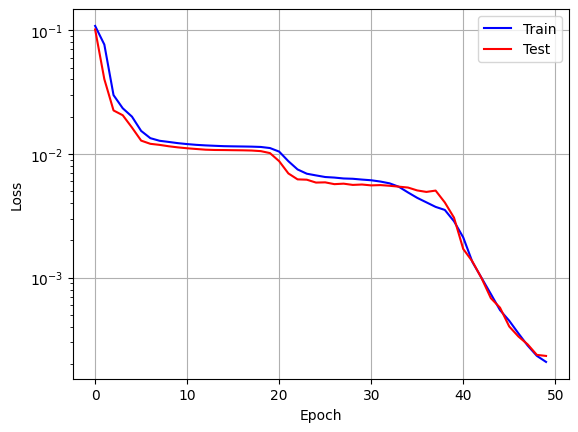

In [11]:
plt.plot(loss_history_train,color='blue')
plt.plot(loss_history_test,color='red')
plt.legend(['Train','Test'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.grid()
plt.show()